In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
df = pd.read_csv('../data/diabetes.csv')
print(df.head())
print(df['Outcome'].value_counts(normalize=True))

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
Outcome
0    0.651042
1    0.348958
Name: proportion, dtype: float64


In [3]:
X = df.drop('Outcome', axis=1).values
y = df['Outcome'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# To tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_ds = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

In [4]:
class DiabetesNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(8, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

model = DiabetesNet()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [5]:
epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1/20, Loss: 0.6549
Epoch 2/20, Loss: 0.6382
Epoch 3/20, Loss: 0.6237
Epoch 4/20, Loss: 0.6059
Epoch 5/20, Loss: 0.5891
Epoch 6/20, Loss: 0.5654
Epoch 7/20, Loss: 0.5383
Epoch 8/20, Loss: 0.5224
Epoch 9/20, Loss: 0.5015
Epoch 10/20, Loss: 0.4874
Epoch 11/20, Loss: 0.4824
Epoch 12/20, Loss: 0.4793
Epoch 13/20, Loss: 0.4757
Epoch 14/20, Loss: 0.4591
Epoch 15/20, Loss: 0.4514
Epoch 16/20, Loss: 0.4458
Epoch 17/20, Loss: 0.4445
Epoch 18/20, Loss: 0.4602
Epoch 19/20, Loss: 0.4486
Epoch 20/20, Loss: 0.4427


In [6]:
model.eval()
with torch.no_grad():
    y_pred_prob = model(X_test_t).numpy().flatten()
    y_pred = (y_pred_prob > 0.5).astype(int)
    
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_prob))
print(classification_report(y_test, y_pred))

Accuracy: 0.7142857142857143
ROC-AUC: 0.8157407407407408
              precision    recall  f1-score   support

           0       0.78      0.78      0.78       100
           1       0.59      0.59      0.59        54

    accuracy                           0.71       154
   macro avg       0.69      0.69      0.69       154
weighted avg       0.71      0.71      0.71       154



In [7]:
from sklearn.model_selection import train_test_split

# Split train into train + val
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_val_t   = torch.tensor(X_val, dtype=torch.float32)
y_val_t   = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds   = TensorDataset(X_val_t, y_val_t)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)

In [8]:
import copy

best_model = None
best_auc = -1
patience = 5
counter = 0

for epoch in range(50):  # more epochs, but early stop
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Validation
    model.eval()
    val_preds = []
    val_labels = []
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item()
            val_preds.extend(outputs.numpy().flatten())
            val_labels.extend(labels.numpy().flatten())
    
    val_auc = roc_auc_score(val_labels, val_preds)
    print(f"Epoch {epoch+1:2d} | Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f} | Val AUC: {val_auc:.4f}")
    
    # Early stopping
    if val_auc > best_auc:
        best_auc = val_auc
        best_model = copy.deepcopy(model)
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Use best model for final eval
model = best_model
model.eval()
with torch.no_grad():
    y_pred_prob = model(X_test_t).numpy().flatten()
    y_pred = (y_pred_prob > 0.5).astype(int)

print("\nFinal Test Results (best model):")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_prob))
print(classification_report(y_test, y_pred))

Epoch  1 | Train Loss: 0.4568 | Val Loss: 0.4123 | Val AUC: 0.8802
Epoch  2 | Train Loss: 0.4465 | Val Loss: 0.4131 | Val AUC: 0.8799
Epoch  3 | Train Loss: 0.4496 | Val Loss: 0.4134 | Val AUC: 0.8802
Epoch  4 | Train Loss: 0.4485 | Val Loss: 0.4142 | Val AUC: 0.8797
Epoch  5 | Train Loss: 0.4520 | Val Loss: 0.4144 | Val AUC: 0.8785
Epoch  6 | Train Loss: 0.4500 | Val Loss: 0.4153 | Val AUC: 0.8785
Early stopping at epoch 6

Final Test Results (best model):
Accuracy: 0.7142857142857143
ROC-AUC: 0.8159259259259259
              precision    recall  f1-score   support

           0       0.78      0.78      0.78       100
           1       0.59      0.59      0.59        54

    accuracy                           0.71       154
   macro avg       0.69      0.69      0.69       154
weighted avg       0.71      0.71      0.71       154



  0%|          | 0/50 [00:00<?, ?it/s]

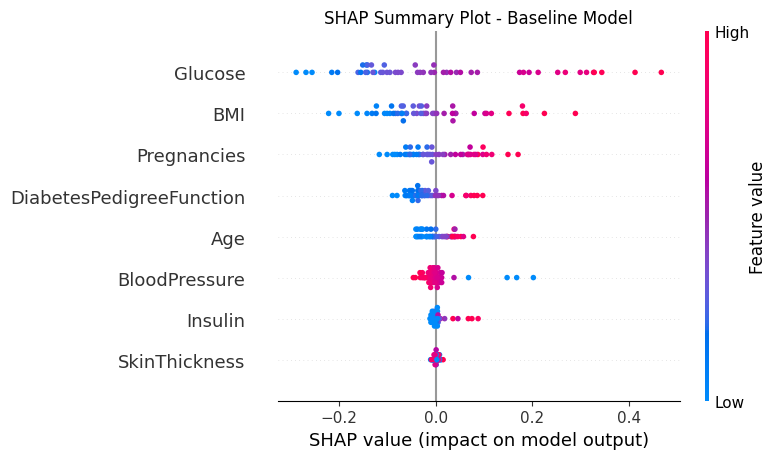

In [10]:
import shap
import matplotlib.pyplot as plt

# Background: use first 100 training samples (good size for KernelExplainer)
background = X_train_t[:100].numpy()   # convert to numpy array

# Wrapper function (already defined – make sure it's above this cell)
def model_predict_proba_numpy(data):
    data_t = torch.tensor(data, dtype=torch.float32)
    with torch.no_grad():
        return model(data_t).numpy().flatten()   # returns 1D array of probabilities

# Create explainer using the FUNCTION we defined
explainer = shap.KernelExplainer(model_predict_proba_numpy, background)

# Compute SHAP values – on a subset of test data to keep it fast (~1-3 minutes)
shap_values = explainer.shap_values(X_test[:50])   # or X_test_t[:50].numpy() if needed

# Summary plot (beeswarm) – shows global feature importance
shap.summary_plot(shap_values, X_test[:50], feature_names=df.columns[:-1], show=False)
plt.title("SHAP Summary Plot - Baseline Model")
plt.tight_layout()
plt.savefig('../results/shap_summary_baseline.png')
plt.show()